In [1]:
# 在倒立摆环境中，引入Double DQN，解决Q值过高的问题
# 以及Dualing DQN，提升Q值的稳定性
# 这两个改进都非常好实现，只需要在DQN的基础上稍作修改即可

In [2]:
# DOUBLE DQN
import random
import gymnasium as gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm
import numpy as np

class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, dqn_type):
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.device = device
        self.dqn_type = dqn_type
        self.count = 0
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.target_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)

    def take_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            state = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
            action = self.q_net(state).argmax().item()
            return action

    def max_q_value(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        state = torch.tensor(transition_dict['state'], dtype=torch.float32).to(self.device)
        action = torch.tensor(transition_dict['action'], dtype=torch.int64).to(self.device).unsqueeze(1)
        reward = torch.tensor(transition_dict['reward'], dtype=torch.float32).to(self.device).unsqueeze(1)
        next_state = torch.tensor(transition_dict['next_state'], dtype=torch.float32).to(self.device)
        done = torch.tensor(transition_dict['done'], dtype=torch.float32).to(self.device).unsqueeze(1)
        # print("shape of state: ", state.shape)
        # print("shape of action: ", action.shape)
        # print("shape of reward: ", reward.shape)
        # print("shape of next_state: ", next_state.shape)
        # print("shape of done: ", done.shape)

        q_value = self.q_net(state).gather(1,action)
        if self.dqn_type == "DoubleDQN":
            max_action = self.q_net(next_state).argmax(dim=1).unsqueeze(1)
            target_q_value = self.target_net(next_state).gather(1, max_action)
        else:
            max_action = self.target_net(next_state).argmax(dim=1).unsqueeze(1)
            target_q_value = self.target_net(next_state).gather(1, max_action)

        q_target = reward + self.gamma * target_q_value * (1 - done)
        # print("shape of q_value: ", q_value.shape)
        # print("shape of q_target: ", q_target.shape)

        dqn_loss = torch.mean(F.mse_loss(q_value, q_target))

        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.target_update is not None and self.count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


/home/zengziyu/mntzzy/anaconda3/envs/RLStudy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env_name = "Pendulum-v1"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11
print(device)

def dis_to_con(discrete_action, env, action_dim):
    action_lowBound = env.action_space.low[0]
    action_highBound = env.action_space.high[0]
    return action_lowBound + (action_highBound - action_lowBound) / (action_dim - 1) * discrete_action

cuda


In [4]:
def train_DQN(agent,env,num_episodes,replay_buffer,minimal_size,batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes/10),
                    desc="Iteration {}".format(i+1)) as pbar:

                for i_episode in range(int(num_episodes/10)):
                    state = env.reset(seed=0)[0]
                    done = False
                    truncated = False
                    total_reward = 0
                    while not done:
                        action = agent.take_action(state)
                        max_q_value = agent.max_q_value(state)*0.005+max_q_value*0.995
                        max_q_value_list.append(max_q_value)
                        action_continuous = dis_to_con(action, env, action_dim)

                        next_state, reward, done, truncated, _ = env.step([action_continuous])
                        done = done or truncated
                        total_reward += reward
                        replay_buffer.add(state, action, reward, next_state, done)
                        state = next_state

                        if replay_buffer.size() > minimal_size:
                            b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                            transition_dict = {'state': b_s, 'action': b_a, 'reward': b_r, 'next_state': b_ns, 'done': b_d}
                            agent.update(transition_dict)
                    return_list.append(total_reward)
                    if (i_episode + 1) %10 == 0:
                        # print("Episode: {}, Reward: {:.2f}, Max Q Value: {:.2f}".format(i_episode + 1, np.mean(return_list[-10:]), max_q_value))
                        pbar.set_postfix({
                            "episode":'%d'%(num_episodes/10*i + i_episode + 1),
                            "reward": '%.2f'%np.mean(return_list[-10:]),
                            "max_q_value": '%.2f'%max_q_value
                        })
                    pbar.update(1)
    return return_list, max_q_value_list

Iteration 10: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s, episode=200, reward=-126.43, max_q_value=4.30]  


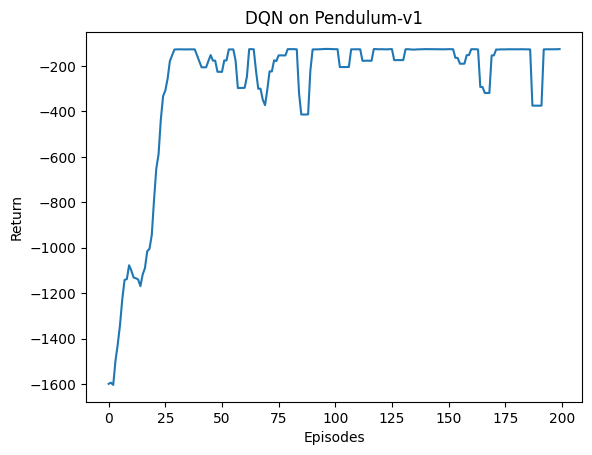

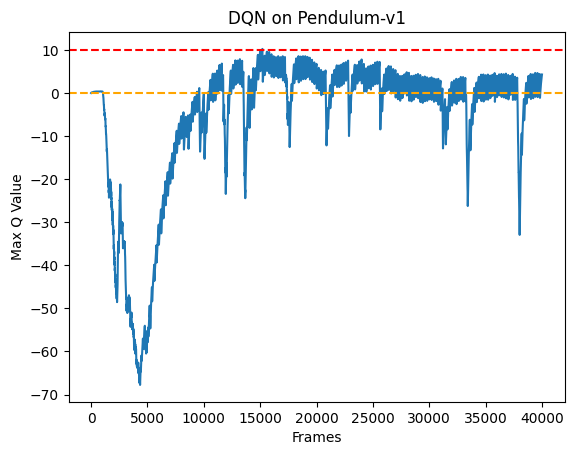

In [5]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, "VanillaDQN")
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

episodes_list = list(range(len(return_list)))
mv_return_list = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return_list)
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title(f"DQN on {env_name}")
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(y=0, color='orange', linestyle='--')
plt.axhline(y=10, color='red', linestyle='--')
plt.xlabel("Frames")
plt.ylabel("Max Q Value")
plt.title(f"DQN on {env_name}")
plt.show()


Iteration 10: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s, episode=200, reward=-235.26, max_q_value=1.41]


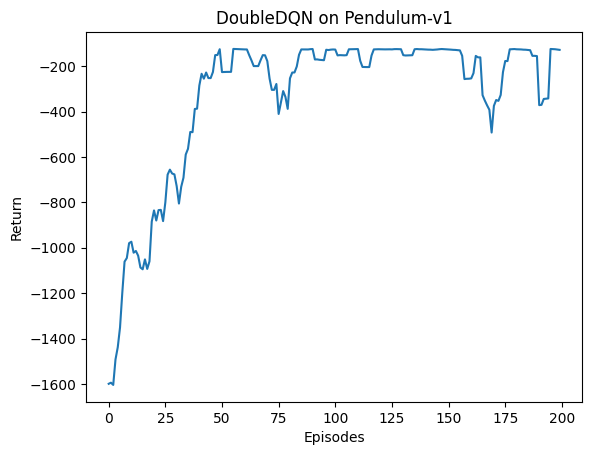

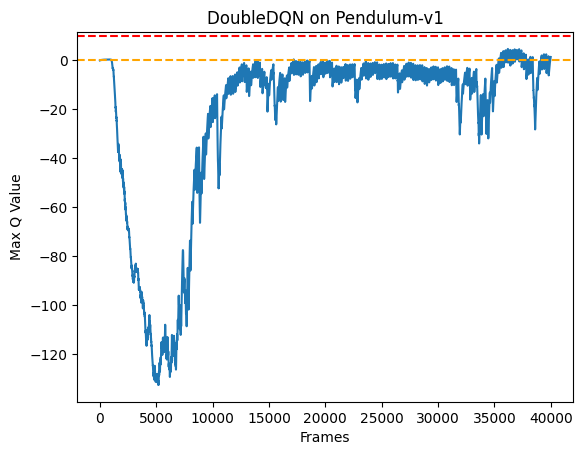

In [6]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, "DoubleDQN")
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

episodes_list = list(range(len(return_list)))
mv_return_list = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return_list)
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title(f"DoubleDQN on {env_name}")
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(y=0, color='orange', linestyle='--')
plt.axhline(y=10, color='red', linestyle='--')
plt.xlabel("Frames")
plt.ylabel("Max Q Value")
plt.title(f"DoubleDQN on {env_name}")
plt.show()


In [7]:
#Dueling DQN Q = V + A
# sigma(A) = 0

class VAnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        A = self.fc_A(x)
        V = self.fc_V(x)
        Q = V + A - A.mean(dim=1, keepdim=True)
        return Q
class DQN:
    def __init__(self, state_dim,hidden_dim,action_dim,lr,gamma,epsilon,target_update,device,dqn_type):
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.device = device
        self.dqn_type = dqn_type
        self.count = 0

        self.q_net = VAnet(state_dim,hidden_dim,action_dim).to(device)
        self.target_net = VAnet(state_dim,hidden_dim,action_dim).to(device)

        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=lr)

    def take_action(self,state):
        if random.random() < self.epsilon:
            return random.randint(0,self.action_dim-1)
        else:
            state = torch.tensor(state,dtype=torch.float32).to(self.device).unsqueeze(0)
            action = self.q_net(state).argmax().item()
            return action

    def max_q_value(self,state):
        state = torch.tensor(state,dtype=torch.float32).to(self.device).unsqueeze(0)
        return self.q_net(state).max().item()

    def update(self,transition_dict):
        state = torch.tensor(transition_dict['state'],dtype=torch.float32).to(self.device)
        action = torch.tensor(transition_dict['action'],dtype=torch.int64).to(self.device).unsqueeze(1)
        reward = torch.tensor(transition_dict['reward'],dtype=torch.float32).to(self.device).unsqueeze(1)
        next_state = torch.tensor(transition_dict['next_state'],dtype=torch.float32).to(self.device)
        done = torch.tensor(transition_dict['done'],dtype=torch.float32).to(self.device).unsqueeze(1)

        q_value = self.q_net(state).gather(1,action)
        if self.dqn_type == "DDDQN":
            max_action = self.q_net(next_state).argmax(dim=1).unsqueeze(1)
            target_q_value = self.target_net(next_state).gather(1,max_action)
        else:
            target_q_value = self.target_net(next_state).max(dim=1)[0].unsqueeze(1)

        q_target = reward + self.gamma * target_q_value * (1-done)

        dqn_loss = torch.mean(F.mse_loss(q_value,q_target))

        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.target_update is not None and self.count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


In [8]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim,hidden_dim,action_dim,lr,gamma,epsilon,target_update,device,"DuelingDQN")
return_list,max_q_value_list = train_DQN(agent,env,num_episodes,replay_buffer,minimal_size,batch_size)


Iteration 10: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it, episode=200, reward=-174.05, max_q_value=7.11]


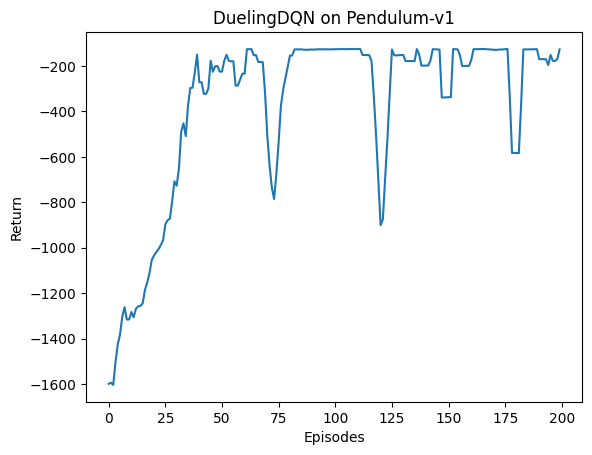

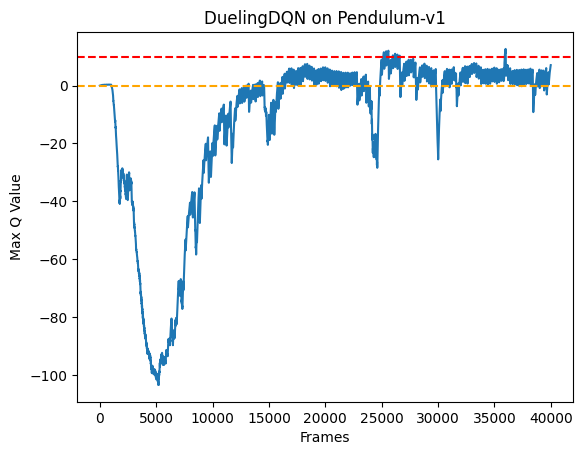

In [9]:

episodes_list = list(range(len(return_list)))
mv_return_list = rl_utils.moving_average(return_list,5)
plt.plot(episodes_list,mv_return_list)
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title(f"DuelingDQN on {env_name}")
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list,max_q_value_list)
plt.axhline(y=0,color='orange',linestyle='--')
plt.axhline(y=10,color='red',linestyle='--')
plt.xlabel("Frames")
plt.ylabel("Max Q Value")
plt.title(f"DuelingDQN on {env_name}")
plt.show()


In [10]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim,hidden_dim,action_dim,lr,gamma,epsilon,target_update,device,"DDDQN")
return_list,max_q_value_list = train_DQN(agent,env,num_episodes,replay_buffer,minimal_size,batch_size)


Iteration 10: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it, episode=200, reward=-313.55, max_q_value=3.11] 


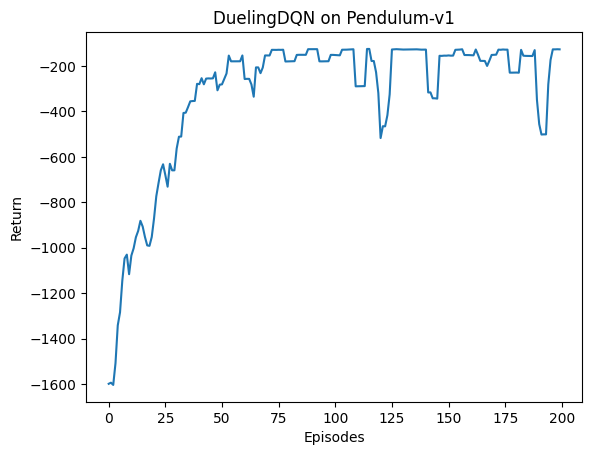

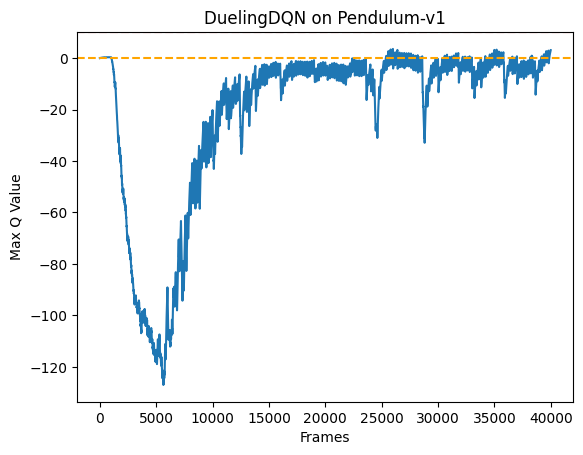

In [11]:

episodes_list = list(range(len(return_list)))
mv_return_list = rl_utils.moving_average(return_list,5)
plt.plot(episodes_list,mv_return_list)
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title(f"DuelingDQN on {env_name}")
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list,max_q_value_list)
plt.axhline(y=0,color='orange',linestyle='--')
plt.axhline(y=10,color='red',linestyle='--')
plt.xlabel("Frames")
plt.ylabel("Max Q Value")
plt.title(f"DuelingDQN on {env_name}")
plt.show()


In [12]:
print(torch.cuda.is_available())

True


In [13]:
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
mean_dim0 = torch.mean(x, dim=0, keepdim=True)
mean_dim1 = torch.mean(x, dim=1, keepdim=True)

print(f"shape of mean_dim0: {mean_dim0.shape}, shape of mean_dim1: {mean_dim1.shape}")

print(f"mean_dim0: {mean_dim0}, mean_dim1: {mean_dim1}")

shape of mean_dim0: torch.Size([1, 2]), shape of mean_dim1: torch.Size([2, 1])
mean_dim0: tensor([[2., 3.]]), mean_dim1: tensor([[1.5000],
        [3.5000]])
